In [1]:
# OverFitting and UnderFitting
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Generate test dataset and labels according to the following third order polybnomial.
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \space where \space \epsilon \sim N(0 , 0.1^2)$$

In [2]:
max_degree = 20
n_train , n_test = 100 , 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5 , 1.2 , -3.4 , 5.6])

# generate initial x 
features = np.random.normal(size=(n_train + n_test , 1))
# shuffle
np.random.shuffle(features)
# using x to get true labels by power operation
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# compress the range of labels
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) 
# add coefficient
labels = np.dot(poly_features, true_w)
# normalize (add noise)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [3]:
true_w , features , poly_features , labels = [
    torch.tensor(x , dtype=torch.float32)
    for x in [true_w , features , poly_features , labels]
]

features.shape ,  features[:2] , poly_features[:2 , :] , labels[:2]

(torch.Size([200, 1]),
 tensor([[1.0214],
         [1.2982]]),
 tensor([[1.0000e+00, 1.0214e+00, 5.2158e-01, 1.7757e-01, 4.5342e-02, 9.2620e-03,
          1.5766e-03, 2.3004e-04, 2.9370e-05, 3.3330e-06, 3.4042e-07, 3.1608e-08,
          2.6902e-09, 2.1136e-10, 1.5420e-11, 1.0499e-12, 6.7022e-14, 4.0267e-15,
          2.2848e-16, 1.2282e-17],
         [1.0000e+00, 1.2982e+00, 8.4264e-01, 3.6464e-01, 1.1834e-01, 3.0726e-02,
          6.6480e-03, 1.2329e-03, 2.0007e-04, 2.8858e-05, 3.7463e-06, 4.4213e-07,
          4.7830e-08, 4.7764e-09, 4.4290e-10, 3.8331e-11, 3.1101e-12, 2.3750e-13,
          1.7129e-14, 1.1703e-15]]),
 tensor([5.4864, 5.7353]))

In [4]:
def evaluate_loss(net , data_iter , loss):
    metric = d2l.Accumulator(2)
    for X , y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out , y)
        metric.add(l.sum() , l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features , test_features , train_labels , test_labels , num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape , 1 , bias=False))
    batch_size = min(10 , train_labels.shape[0])
    train_iter = d2l.load_array((train_features , train_labels.reshape(-1 , 1)) , batch_size)
    test_iter = d2l.load_array((test_features , test_labels.reshape(-1 , 1)) , batch_size , is_train=False)

    trainer = torch.optim.SGD(net.parameters() , lr=0.01)
    animator = d2l.Animator(xlabel='epoch' , ylabel='loss' , yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net , train_iter , loss , trainer , )
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[3.6923013 3.0473075]]


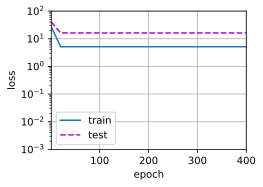

In [6]:
# underfitting
train(poly_features[:n_train , :2] , poly_features[n_train: , :2] , labels[:n_train] , labels[n_train:])


weight: [[ 4.994589   1.1757858 -3.3916888  5.6110544]]


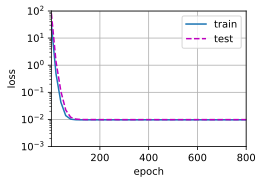

In [7]:
# normal
train(poly_features[:n_train , :4] , poly_features[n_train: , :4] , labels[:n_train] , labels[n_train:] , num_epochs=800)

weight: [[ 4.990825    1.2709615  -3.3671916   5.187738   -0.08675062  0.8331976
   0.3084096   0.03572635  0.21131484  0.14601775 -0.08477986 -0.16149916
   0.01945204 -0.14573544  0.12567434  0.21825567  0.01906434 -0.21548015
  -0.19027837  0.18145308]]


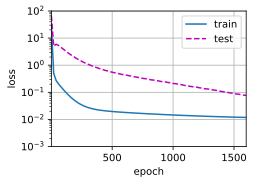

In [9]:
# overfitting
train(poly_features[:n_train , :20] , poly_features[n_train: , :20] , labels[:n_train] , labels[n_train:] , num_epochs=1600)